---
---
# Transfer Learning - CNN
---
---

In this Demo we will be introducing the transfer learning concept

Please use the GPU in Google Colab to significantly speed up the training time for machine learning models that use TensorFlow, PyTorch, or other frameworks. Google Colab provides free access to GPUs and TPUs to accelerate computational tasks. Here's how you can set up and use a GPU in Google Colab:

 **Change the runtime type to GPU**:
   - Go to the menu at the top of the notebook and click on `Runtime`.
   - Select `Change runtime type` from the dropdown menu.
   - A dialog box will appear. Under "Hardware accelerator," choose `GPU` from the dropdown menu.
   - Click `Save` to apply the changes. This will restart your Colab environment with GPU support.


## Libraries Imports

In [1]:
#import tensorflow and keras
import tensorflow as tf
import keras
from keras import layers, models, datasets, applications

#import pandas and matplotlib for accurcy visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import time


In [2]:
# Ensure GPU availability
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPUs found. Running on CPU instead.")


No GPUs found. Running on CPU instead.


## Loading Data

The above method truly shines when used with big images and especially multi-channel images

**The CIFAR-100** dataset is a well-known dataset used in machine learning and computer vision for evaluating image recognition algorithms. It is a more complex and diverse dataset compared to its counterpart, CIFAR-10, primarily due to the larger number of classes.

![Cifar100](https://datasets.activeloop.ai/wp-content/uploads/2022/09/CIFAR-100-dataset-Activeloop-Platform-visualization-image.webp)

>- CIFAR-100 contains 60,000 32x32 color images.
>- The images are divided into 100 classes, each containing 600 images.
>- The 100 classes are grouped into 20 superclasses.
>- Each superclass encompasses several classes that are more specific; for example, the "aquatic mammals" superclass includes classes like "beaver", "dolphin", and "otter".

In [3]:
# Loading the Dataset from Keras
cifar = datasets.cifar100
(X_train_full, y_train_full), (X_test, y_test) = cifar.load_data(label_mode='coarse')

#Spliting the training Dataset into train and validation
X_valid, X_train = X_train_full[:4000] / 255.0, X_train_full[4000:] / 255.0
y_valid, y_train = y_train_full[:4000], y_train_full[4000:]

In [4]:
print('Full Data:', X_train_full.shape)
print('Training Data:', X_train.shape)
print('Validation Data:', X_valid.shape)

Full Data: (50000, 32, 32, 3)
Training Data: (46000, 32, 32, 3)
Validation Data: (4000, 32, 32, 3)


In [5]:
print('Labels are ', np.unique(y_train))

Labels are  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


## Simple CNN

Let's begin with our CNN from scratch

In [6]:
def create_simple_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(20, activation='softmax')
    ])
    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [7]:
# Create and train the simple CNN
simple_cnn_model = create_simple_cnn()
simple_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0

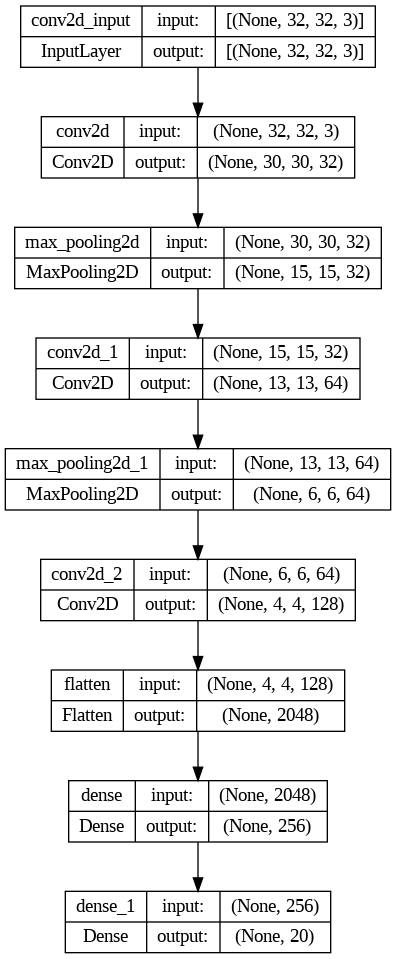

In [8]:
# Display the model's architecture
keras.utils.plot_model(simple_cnn_model, "cnn.png", show_shapes=True)

In [9]:
# Train the model
start_time = time.time()
history = simple_cnn_model.fit(X_train, y_train, batch_size=5000, epochs=5, validation_data=(X_valid, y_valid))
simple_cnn_time = time.time() - start_time

simple_cnn_acc = history.history['accuracy'][-1:][0]
simple_cnn_val_acc = history.history['val_accuracy'][-1:][0]

Epoch 1/5
10/10 [==============================] - 67s 6s/step - loss: 2.8927 - accuracy: 0.1039 - val_loss: 2.7628 - val_accuracy: 0.1650
Epoch 2/5
10/10 [==============================] - 63s 6s/step - loss: 2.7037 - accuracy: 0.1750 - val_loss: 2.6208 - val_accuracy: 0.2150
Epoch 3/5
10/10 [==============================] - 61s 6s/step - loss: 2.5605 - accuracy: 0.2219 - val_loss: 2.5140 - val_accuracy: 0.2330
Epoch 4/5
10/10 [==============================] - 61s 6s/step - loss: 2.4646 - accuracy: 0.2502 - val_loss: 2.4153 - val_accuracy: 0.2570
Epoch 5/5
10/10 [==============================] - 60s 6s/step - loss: 2.3832 - accuracy: 0.2733 - val_loss: 2.3416 - val_accuracy: 0.2743


In [10]:
#Model evaluating
simple_cnn_tst_acc = simple_cnn_model.evaluate(X_test, y_test)[1]

313/313 [==============================] - 6s 19ms/step - loss: 272.7045 - accuracy: 0.2310


## Transfer Learning

Transfer learning is a powerful technique in machine learning where a model developed for one task is reused as the starting point for a model on a second task. It is a popular approach in deep learning where pre-trained models are used as the starting point on new problems.



The main idea behind transfer learning is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. The learned features from this model (weights of the neurons) can then be used to extract meaningful features from new datasets that are too small to train a deep neural network from scratch.

### Why Use Transfer Learning?
1. **Speeds up Development**: Training a deep learning model from scratch requires significant amounts of data and computational power. Transfer learning can significantly reduce the training time and computational cost.
2. **Improves Performance**: When the amount of training data available for a new task is limited, using a model pre-trained on a larger dataset can improve performance.
3. **Leverages Existing Knowledge**: It is a method of leveraging knowledge (features, weights) from previously learned tasks and applying them to solve new, but related, problems.

In [23]:
def create_transfer_learning_model():
    base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    base_model.trainable = False  # Freeze the base model

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(20, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

### How Transfer Learning Works:
1. **Select a Source Model**: A pre-trained model is chosen typically trained on a large benchmark dataset such as ImageNet (for image-related tasks). This model has already learned a lot of features that are universally useful for many other tasks involving images.
2. **Reuse Model**: The pre-trained model can be used in two ways:
   - **Feature Extraction**: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new output layer, that will be trained from scratch, on top of the pre-trained model so that you can repurpose the feature maps learned previously for the dataset.
   - **Fine-Tuning**: Instead of randomly initializing the weights of a model, the weights are initialized with the weights from a pre-trained model. A few layers of this model are then fine-tuned by continuing the backpropagation. It’s possible to fine-tune all the layers of the model, or just some of the deeper layers. This method is more flexible but also more risky, particularly when you do not have a lot of data.

In [24]:
# Create and train the transfer learning model
transfer_learning_model = create_transfer_learning_model()
transfer_learning_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d_3  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                32832     
                                                                 
 dense_9 (Dense)             (None, 20)                1300      
                                                                 
Total params: 14748820 (56.26 MB)
Trainable params: 34132 (133.33 KB)
Non-trainable params: 14714688 (56.13 MB)
________

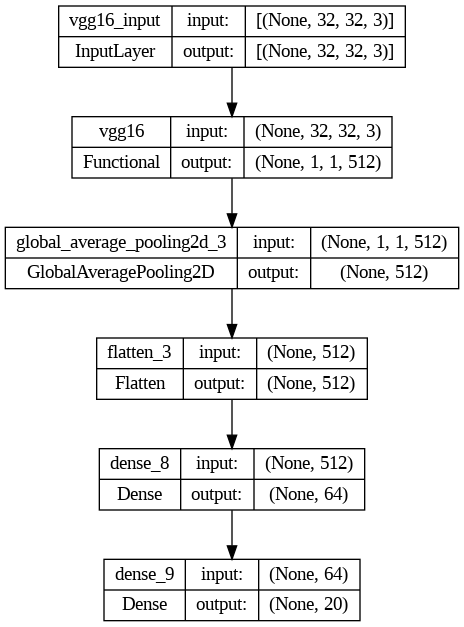

In [25]:
# Display the model's architecture
keras.utils.plot_model(transfer_learning_model, "transfer_cnn.png", show_shapes=True)

In [26]:
# Train the model
start_time = time.time()
history = transfer_learning_model.fit(X_train, y_train, batch_size=5000, epochs=5, validation_data=(X_valid, y_valid))
transfer_learning_time = time.time() - start_time

transfer_learning_acc = history.history['accuracy'][-1:][0]
transfer_learning_val_acc = history.history['val_accuracy'][-1:][0]

Epoch 1/5
10/10 [==============================] - 562s 57s/step - loss: 2.9842 - accuracy: 0.0864 - val_loss: 2.8484 - val_accuracy: 0.1297
Epoch 2/5
10/10 [==============================] - 559s 56s/step - loss: 2.7744 - accuracy: 0.1865 - val_loss: 2.6603 - val_accuracy: 0.2132
Epoch 3/5
10/10 [==============================] - 559s 56s/step - loss: 2.5814 - accuracy: 0.2415 - val_loss: 2.4801 - val_accuracy: 0.2492
Epoch 4/5
10/10 [==============================] - 565s 57s/step - loss: 2.4187 - accuracy: 0.2754 - val_loss: 2.3471 - val_accuracy: 0.2822
Epoch 5/5
10/10 [==============================] - 560s 56s/step - loss: 2.3002 - accuracy: 0.3045 - val_loss: 2.2498 - val_accuracy: 0.3140


In [28]:
#Model evaluating
transfer_learning_tst_acc = transfer_learning_model.evaluate(X_test, y_test)[1]

313/313 [==============================] - 105s 334ms/step - loss: 56.6182 - accuracy: 0.1940


### Model Comparsion

In [32]:
# Print comparison
print("Simple CNN - Train Accuracy: {:.2f}%, Time: {:.2f} seconds, Val Accuracy: {:.2f}%, Test Accuracy: {:.2f}%".format(simple_cnn_acc * 100.00, simple_cnn_time, simple_cnn_val_acc * 100.00, simple_cnn_tst_acc * 100.00))
print("Transfer Learning - Train Accuracy: {:.2f}%, Time: {:.2f} seconds, Val Accuracy: {:.2f}%, Test Accuracy: {:.2f}%".format(transfer_learning_acc * 100.00, transfer_learning_time, transfer_learning_val_acc * 100.00, transfer_learning_tst_acc * 100.00))


Simple CNN - Train Accuracy: 27.33%, Time: 326.87 seconds, Val Accuracy: 27.43%, Test Accuracy: 23.10%
Transfer Learning - Train Accuracy: 27.33%, Time: 2844.74 seconds, Val Accuracy: 27.43%, Test Accuracy: 19.40%
